# FCA sn analysis for MALES - Germ cells reanalysis

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures-sn/clustering_males/germcells/'
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

'/home/jovyan/my-conda-envs/sc_analysis/bin/python'

## Load data

In [3]:
path2gonads = '/nfs/users/nfs_l/lg18/team292/lg18/with_valentina/gonadsV2_revision/'
adataHrv15 = sc.read(path2gonads+'multiomics_rna_counts_denoised_Hrv15.h5ad')
adataHrv3 = sc.read(path2gonads+'multiomics_rna_counts_denoised_Hrv3.h5ad')
adataHrv41 = sc.read(path2gonads+'multiomics_rna_counts_denoised_Hrv41.h5ad')

In [4]:
adata = adataHrv41.concatenate(adataHrv15, adataHrv3, join='outer', index_unique=None)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=300)

filtered out 1938 genes that are detected in less than 3 cells
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
filtered out 430 cells that have less than 300 genes expressed


In [5]:
adata.obs['pcw'] = '19'
adata.obs.loc[(adata.obs.donor == 'Hrv15' ),'pcw']= '12'
adata.obs.loc[(adata.obs.donor == 'Hrv41' ),'pcw']= '8.8'

In [6]:
# Add old cluster subname
meta_male1 = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV2_revision/multiomics_male_Hrv3.csv')
meta_male1 = meta_male1.set_index('Unnamed: 0')
meta_male1.head()

# Add old cluster subname
meta_male2 = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV2_revision/multiomics_male_Hrv15.csv')
meta_male2 = meta_male2.set_index('Unnamed: 0')
meta_male2.head()

# Add old cluster subname
meta_male3 = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV2_revision/multiomics_male_Hrv41.csv')
meta_male3 = meta_male3.set_index('Unnamed: 0')
meta_male3.head()



meta_male1 = meta_male1['clusters'].to_dict()
meta_male2 = meta_male2['clusters'].to_dict()
meta_male3 = meta_male3['clusters'].to_dict()
cell_annot = {**meta_male1, **meta_male2, **meta_male3}
adata.obs['lineage'] = adata.obs_names.map(cell_annot).astype('category')

In [7]:
adata.obs['lineage'].value_counts()

Sertoli              6310
Mesenchymal_LHX9     2583
Mesenchymal_GATA2    1635
FetalLeydig          1190
GermCells             739
early_sPAX8           686
lowQC                 552
Doublet               487
CoelEpi               344
Immune                315
Epithelial            240
Endothelial           235
Sertoli_lowQC         147
PV                      7
Name: lineage, dtype: int64

In [8]:
# Add old cluster subname
meta_male1 = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV2_revision/multiomics_male_germcells_Hrv15.csv')
meta_male1 = meta_male1.set_index('Unnamed: 0')
meta_male1.head()

cell_annot = meta_male1['clusters'].to_dict()
adata.obs['celltype_samplespecific'] = adata.obs_names.map(cell_annot).astype('category')

## Filter germ cells

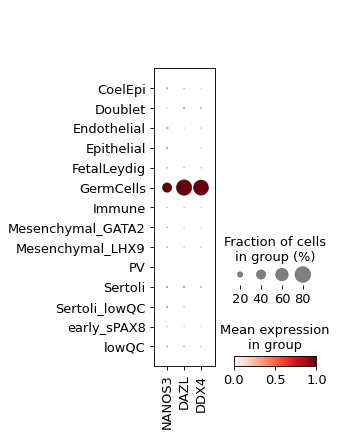

In [10]:
sc.pl.dotplot(adata, ['NANOS3', 'DAZL', 'DDX4'], groupby='lineage', standard_scale='var')

In [11]:
adata = adata[[ i in ['GermCells'] for i in adata.obs['lineage']]]

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 739
Total number of genes: 32059


### Identify HVGs

In [13]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000, subset=False)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
Trying to set attribute `.uns` of view, copying.
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


### Normalize per cell and log transform

After removing unwanted cells and genes from the dataset, the next step is to normalize the data. 
By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. 

In [14]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Score cell cycle

In [15]:
s_genes = [x.strip() for x in open('/home/jovyan/utils/S_genes.tsv')]
g2m_genes = [x.strip() for x in open('/home/jovyan/utils/G2M_genes.tsv')]

s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

In [16]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    459 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    419 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


### Filter HVGs in bdata and do PCA with them

In [17]:
bdata = adata[:, adata.var['highly_variable']]
print('Total number of cells: {:d}'.format(bdata.n_obs))
print('Total number of genes: {:d}'.format(bdata.n_vars))

Total number of cells: 739
Total number of genes: 2000


/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [18]:
sc.pp.scale(bdata, max_value=10)
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


## Transfer PCA to the main adata

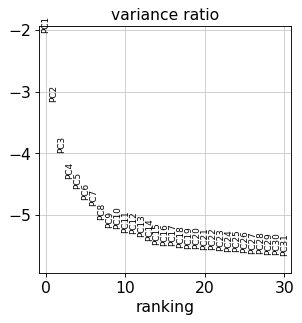

In [19]:
#fill NaNs with False so that subsetting to HVGs is possible
adata.var['highly_variable'].fillna(value=False, inplace=True)
adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
adata.uns['pca'] = bdata.uns['pca'].copy()
adata.varm['PCs'] = np.zeros(shape=(adata.n_vars, 50))
adata.varm['PCs'][adata.var['highly_variable']] = bdata.varm['PCs']
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')

## HARMONY correction

In [20]:
# Extract PCA matrix and batch array
n_pcs = 7
pca = adata.obsm['X_pca'][:, 0:(n_pcs)]
# batch = adata.obs['individual']

In [21]:
import harmonypy as hm
ho = hm.run_harmony(pca, adata.obs, 'sample', theta = 0)

2021-09-21 10:16:49,112 - harmonypy - INFO - Iteration 1 of 10
2021-09-21 10:16:49,195 - harmonypy - INFO - Iteration 2 of 10
2021-09-21 10:16:49,287 - harmonypy - INFO - Iteration 3 of 10
2021-09-21 10:16:49,371 - harmonypy - INFO - Iteration 4 of 10
2021-09-21 10:16:49,453 - harmonypy - INFO - Iteration 5 of 10
2021-09-21 10:16:49,537 - harmonypy - INFO - Iteration 6 of 10
2021-09-21 10:16:49,600 - harmonypy - INFO - Iteration 7 of 10
2021-09-21 10:16:49,632 - harmonypy - INFO - Iteration 8 of 10
2021-09-21 10:16:49,660 - harmonypy - INFO - Iteration 9 of 10
2021-09-21 10:16:49,684 - harmonypy - INFO - Iteration 10 of 10
2021-09-21 10:16:49,712 - harmonypy - INFO - Stopped before convergence


In [22]:
# Add harmony values to the anndata object
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
adata.obsm['X_pca'] = res.to_numpy().T

### UMAP

In [23]:
# Visualize
sc.pp.neighbors(adata, n_pcs = n_pcs)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 7
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


## Clustering the graph
As Seurat and many others, we use the leiden graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by Levine et al. (2015).

In [26]:
sc.tl.leiden(adata, resolution=0.3)
# sc.tl.leiden(adata, resolution=0.2)

running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


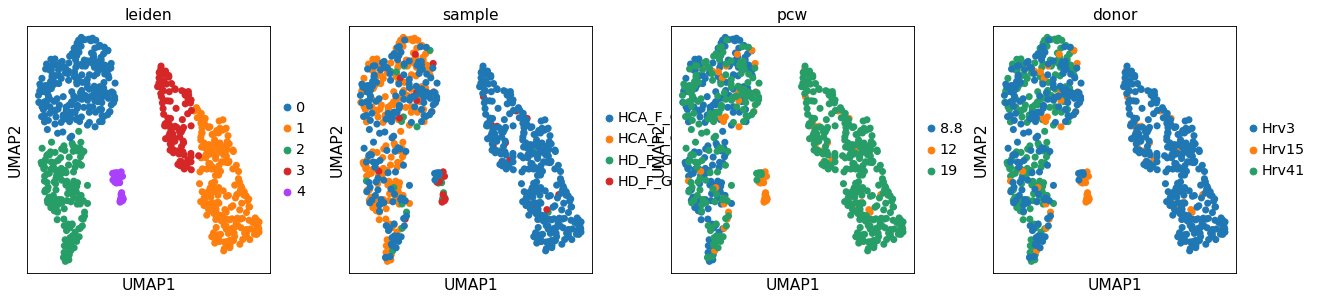

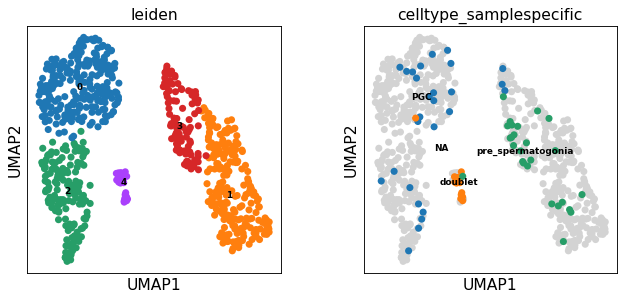

In [27]:
sc.pl.umap(adata, color=['leiden', 'sample', 'pcw', 'donor'] )
sc.pl.umap(adata, color=['leiden', 'celltype_samplespecific'],legend_loc='on data', legend_fontsize=8 )

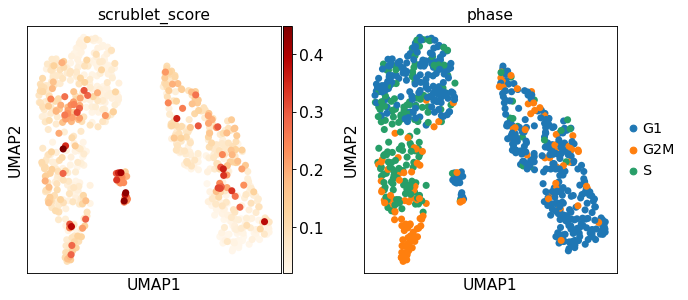

In [28]:
sc.pl.umap(adata, color=['scrublet_score', 'phase'], color_map='OrRd', use_raw=False )

### Visualize general markers

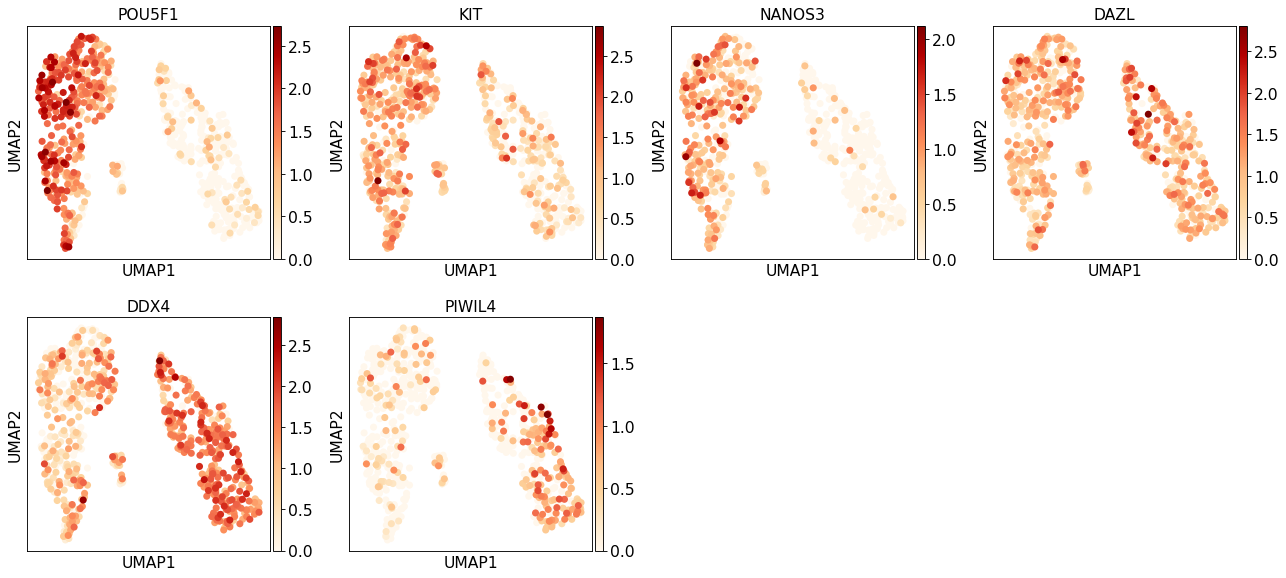

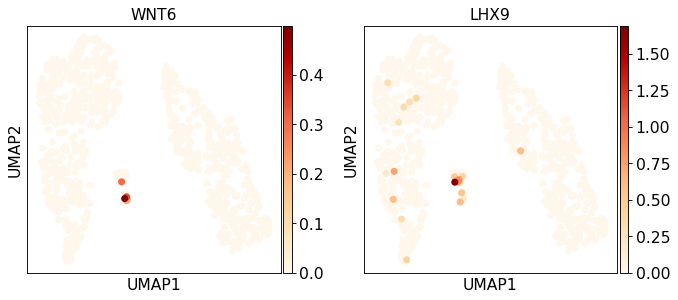

In [30]:
sc.pl.umap(adata, color=['POU5F1', 'KIT', 'NANOS3', 'DAZL', 'DDX4', 'PIWIL4'], color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['WNT6', 'LHX9'], color_map='OrRd', use_raw=False )

### Check global trends

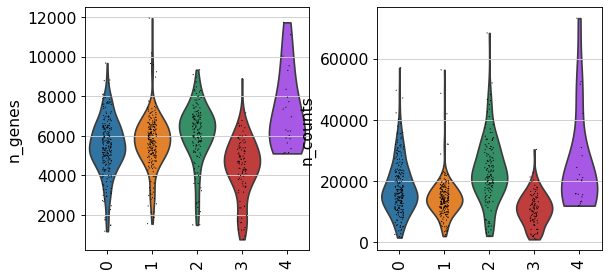

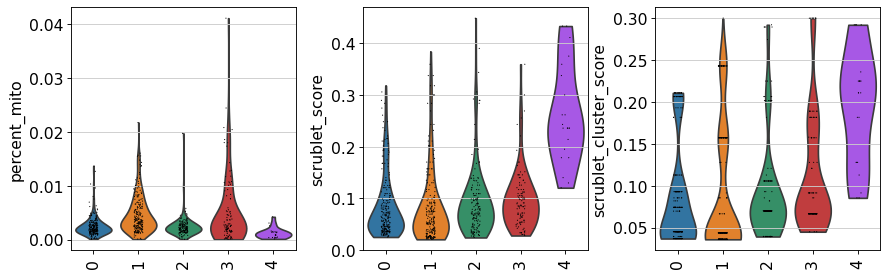

In [31]:
sc.pl.violin(adata, keys= ['n_genes', 'n_counts'], groupby = 'leiden', save='_clusters_statsI.pdf', rotation = 90)
sc.pl.violin(adata, keys= ['percent_mito', 'scrublet_score', 'scrublet_cluster_score'], groupby = 'leiden', save='_clusters_statsII.pdf', rotation = 90)

# Finding marker genes

Compute a ranking for the highly differential genes in each cluster. Here, we simply rank genes with a t test, which agrees quite well with Seurat.

## All vs rest

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


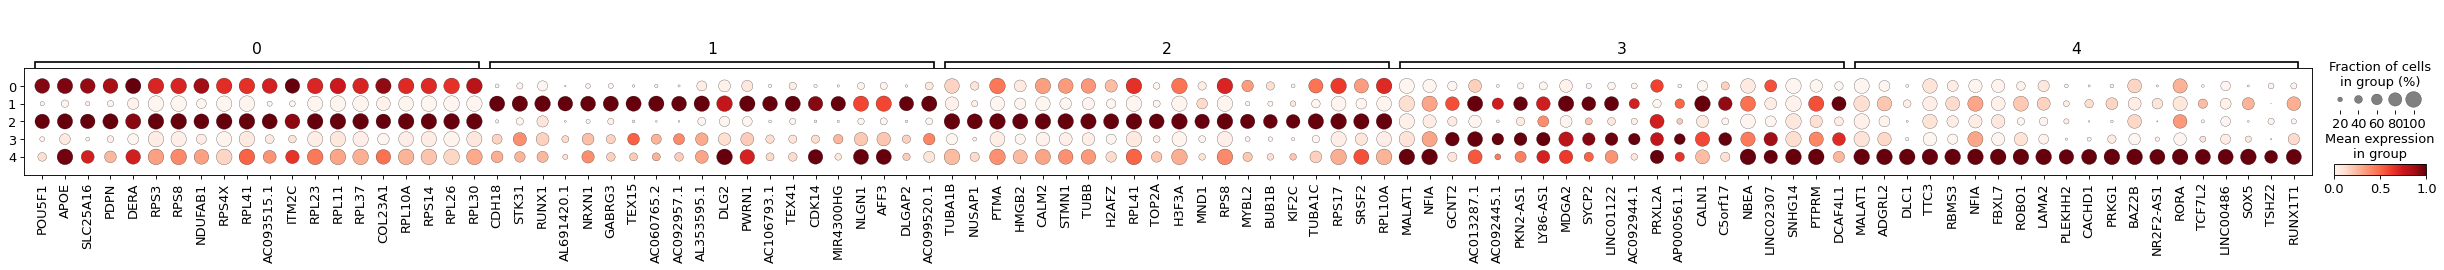

In [32]:
#Compute Mann-Withney test with scanpy
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=False) #, method='logreg'
#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata, n_genes=20, dendrogram=False, save='_scanpy.pdf', standard_scale = 'var')

In [33]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()


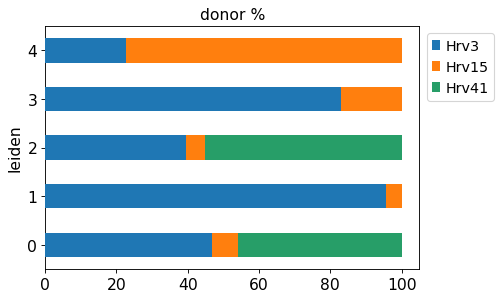

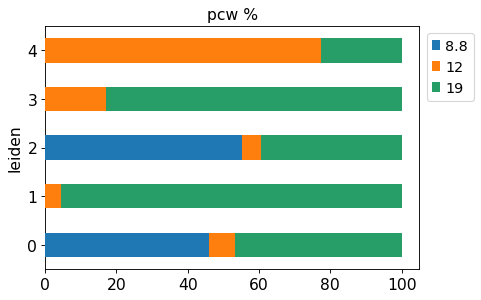

In [34]:
Barplot('donor', adata, var='leiden', height=4)
Barplot('pcw', adata, var='leiden', height=4)

In [35]:
marker_genes = {
    'PGCs':{'POU5F1', 'NANOG', 'NANOS3'},
                'PGCs_migrating':{'XIST'},
                'GCs':{'DAZL', 'DDX4', 'MAEL'},
#                 'oogenesis':{'ZGLP1'}, 
#                 'RA':{'STRA8', 'ESX1'}, 
#                 'meiosis':{'MEIKIN', 'SYCP1', 'MEIOC'}, 
#                 'oocyte':{'FIGLA', 'NOBOX', 'OOSP2'}, 
# #                 'oocyte':{'OOSP2', 'GDF9', 'ZP3', 'FOXO3','SOHLH1', 'SOHLH2', 'NOBOX', 'LHX8', 'YBX2', 'TSC2'},
                'pre_spermatogonia':{'MORC1', 'PIWIL4', 'NKAPL', 'VCX3A'},
        'Supporting':{'NR5A1', 'WNT6', 'WIPF3'},
        'Mesenchymal':{'DCN', 'PDGFRA', 'COL1A1', 'TCF21'},
    'Immune': {'PTPRC'},
    'Endothelial': {'CDH5'},
    'Epithelial': {"EPCAM", 'PAX8'},#, 'KRT7', 'CLDN4', 'RAB25'},
    'Erythroid': {"GYPC", "HBA1"},
    'Neural': {'ASCL1', 'ELAVL4', 'PLP1', 'MPZ', 'CHL1'},
    'Erythroid': {"GYPC", "HBA1"},
                'cycling':{'CDK1', 'MKI67'}  
}

In [36]:
marker_matches = sc.tl.marker_gene_overlap(adata, marker_genes, method = 'overlap_coef')
marker_matches = marker_matches.set_axis('cl_'+marker_matches.columns, axis=1, inplace=False)

<AxesSubplot:>

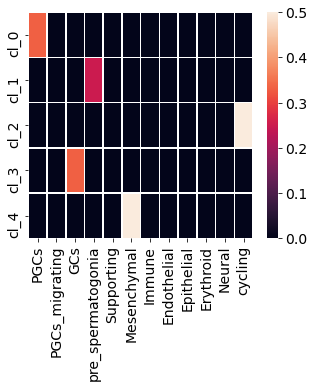

In [37]:
from pandas import DataFrame
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,4))  
sns.heatmap(marker_matches.T, annot=False, xticklabels=True, yticklabels=True, linewidths=0.5, ax= ax)

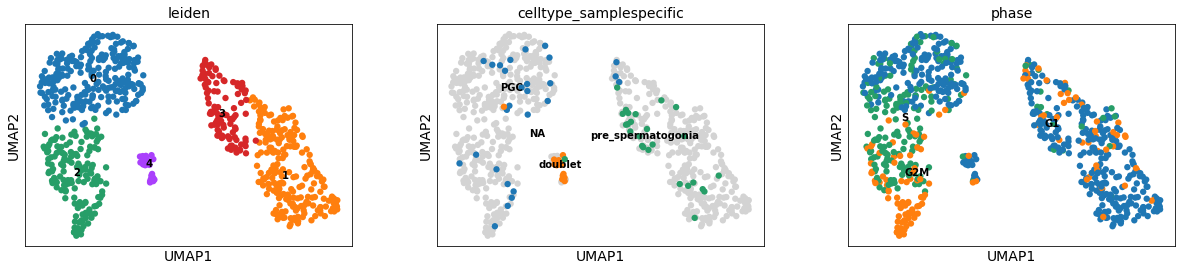

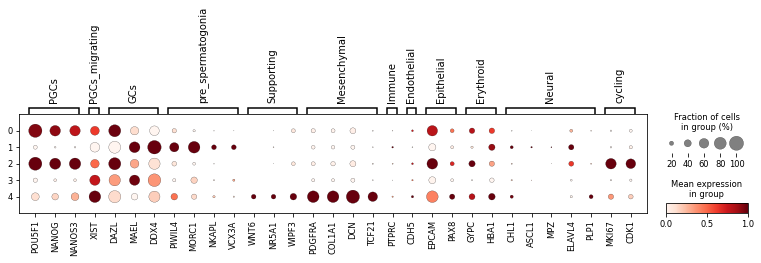

In [39]:
sc.pl.umap(adata, color=['leiden', 'celltype_samplespecific', 'phase'],legend_loc='on data')
sc.pl.dotplot(adata, marker_genes, groupby='leiden', standard_scale='var')

... storing 'celltype' as categorical


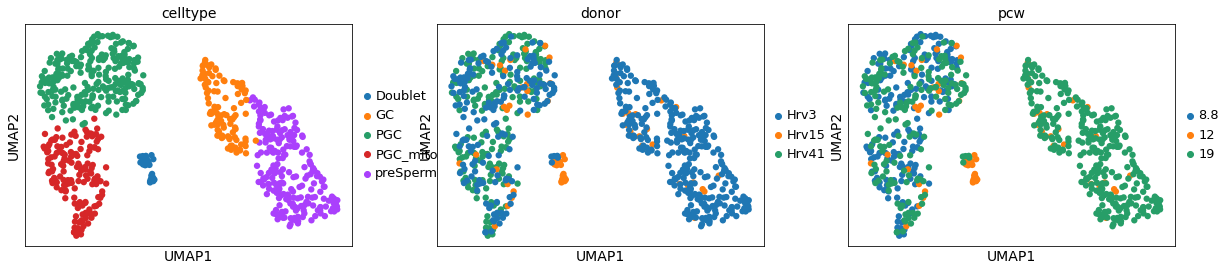

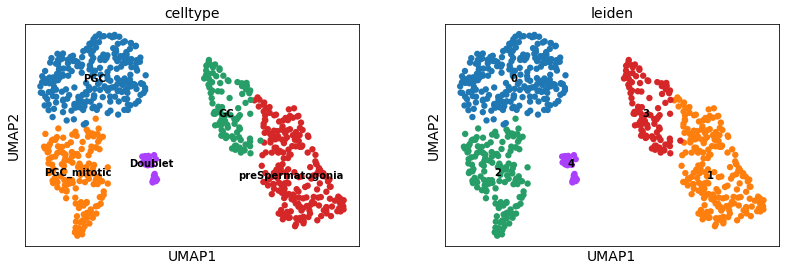

In [44]:
adata.obs['celltype'] = adata.obs['leiden'].tolist()
adata.obs.at[adata.obs['celltype'] == '0', 'celltype'] = 'PGC'
adata.obs.at[adata.obs['celltype'] == '1', 'celltype'] = 'preSpermatogonia'
adata.obs.at[adata.obs['celltype'] == '2', 'celltype'] = 'PGC_mitotic'
adata.obs.at[adata.obs['celltype'] == '3', 'celltype'] = 'GC'
adata.obs.at[adata.obs['celltype'] == '4', 'celltype'] = 'Doublet'
set(adata.obs['celltype'])
sc.pl.umap(adata, color=['celltype', 'donor', 'pcw'])
adata.obs['celltype'].cat.reorder_categories(['PGC',  'PGC_mitotic','GC',
                                               'preSpermatogonia', 'Doublet'], inplace=True)

sc.pl.umap(adata, color=['celltype', 'leiden'], legend_loc='on data')

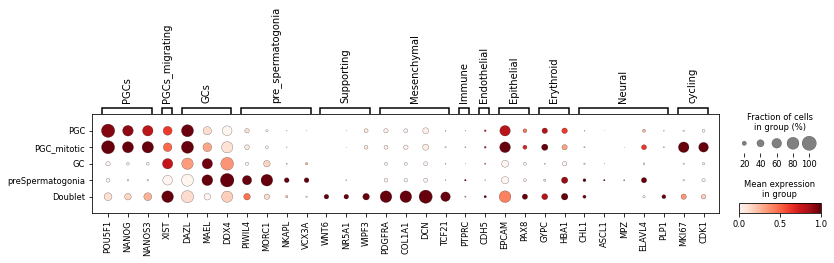

In [45]:
sc.pl.dotplot(adata, marker_genes, groupby='celltype', standard_scale='var')

In [46]:
adata.obs['celltype'].values.describe()

,counts,freqs
categories,,
PGC,239,0.323410
PGC_mitotic,152,0.205683
GC,105,0.142084
preSpermatogonia,221,0.299053
Doublet,22,0.029770


## Save adata

In [47]:
pd.DataFrame(adata.obs).to_csv('/nfs/team292/lg18/with_valentina/gonadsV2_revision/multiomics_male_germcells.csv')